## Data we are working with

Summary of EDA and how the data was pulled:
- used wikipedia to pull list of artists and fed it back into the itunes API to retrieve album-only information in the form of json txt files containing all info available to that album
- artists can have multiple items
- extracted all info from json files into data frame including artwork URL 100 (in "final" dataframe)
- another folder houses all the album art as jpgs on my hard drive (this would be the features). all jpg file names correlate to the index in the dataframe +1 (no 0.jpg)

In [1]:
import pandas as pd
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
final = pd.read_csv("final_pull.csv")
del final["Unnamed: 0"]
final.head()

,artistName,artworkUrl100,releaseDate,collectionName,decade,updated_genre,target
0,Admiral Bailey,http://is5.mzstatic.com/image/thumb/Music/v4/0...,1987-06-09T07:00:00Z,The Best of Admiral Bailey,1980.0,Reggae,Reggae-1980.0
1,Admiral Bailey,http://is3.mzstatic.com/image/thumb/Music/v4/0...,1988-01-01T08:00:00Z,Big Belly,1980.0,Reggae,Reggae-1980.0
2,Admiral Bailey,http://is4.mzstatic.com/image/thumb/Music/v4/3...,1987-06-09T07:00:00Z,Best of Admiral Bailey,1980.0,Reggae,Reggae-1980.0
3,Admiral Bailey,http://is5.mzstatic.com/image/thumb/Music/v4/2...,2006-06-24T07:00:00Z,Admiral Bailey's Turn Off the Heat - EP,2000.0,World,World-2000.0
4,Admiral Bailey,http://is5.mzstatic.com/image/thumb/Music/v4/8...,2011-06-20T07:00:00Z,Dela Move,2010.0,Reggae,Reggae-2010.0


In [14]:
genre_decade = pd.pivot_table(final, index = ["updated_genre", "decade"], values = ["artistName"], aggfunc = len).unstack()
genre_decade

artistName                     
decade                1980.0 1990.0 2000.0 2010.0
updated_genre                                    
Alternative              401   1527   6718   7961
Blues                     13    112    545    406
Country                  202   1023   4098   4931
Dance                     91    686   7278  18717
Electronic                71    966   5275   8165
HipHop                    21    266   2444   4441
Jazz                      83    329   1481   1564
Pop                      277    889   4718   7438
RB Soul                   62    267   1167   1523
Reggae                   185    633   3233   6821
Rock                     576   1945   9243  10537
Singer/Songwriter         69    224   1094   1696
World                    118    567   2150   2176

In [16]:
genre_decade.sum()

            decade
artistName  1980.0     2169
            1990.0     9434
            2000.0    49444
            2010.0    76376
dtype: int64

In [17]:
genre_decade.T.sum()

updated_genre
Alternative          16607
Blues                 1076
Country              10254
Dance                26772
Electronic           14477
HipHop                7172
Jazz                  3457
Pop                  13322
RB Soul               3019
Reggae               10872
Rock                 22301
Singer/Songwriter     3083
World                 5011
dtype: int64

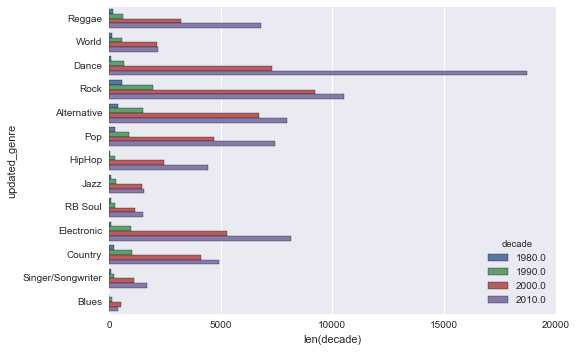

In [11]:
sns.barplot(x = "decade", y = "updated_genre", hue = "decade", data = final, estimator = len)

In [12]:
len(final)

137423

With 137,423 total values, as a whole the data set should be large enough to work with. However, distribution shows that there's a huge skew towards the earlier decades (especially this recent decade of 2010-2016).

Also, Dance, Rock, and Electronic are huge genres especially compared to genres like the Blues in which there are only under triple digits for some of the decades. This might prove to be really difficult to train a model on a target of genre-decade compared to training on only genre or only the decade.

## Model Buildling

The original target was supposed to be the "target" column of the final dataframe. This was a mixture of both genre and decade. But, given the issue with the data as noted above, we'll test out a few targets.

Process:
1. Choose a target to test (1. Genre-decade, 2. Genre, 3. Decade)
2. Stratify a small sample to test and train before going full blown
3. Perform feature detection and extraction
4. Clustering - try KMeans or Hierarchical
5. Final model will be SVM

### 1. Choose a Target: Genre-Decade

In [21]:
y_genredecade = final["target"]

### 2. Stratify a small sample to test and train before going full blown

In [116]:
#take 20% of sample - this pulls only the indices
from sklearn.cross_validation import StratifiedShuffleSplit
y_test, y_nottest = StratifiedShuffleSplit(y_genredecade, n_iter = 2, test_size = 0.20, random_state = 77)

In [117]:
#since this has two splits, choose the first one and take the one that's only 20%
for i in y_test:
    print len(i)

109939
27484


In [118]:
#confirm that y_test is now 15% of sample
y_test = y_test[1]
len(y_test)

27484

In [119]:
print y_test

[ 79127  30725 105327 ...,  89530  29975  92084]


In [120]:
#repull list of y_genredecade
y_test_genredecade = [final.iloc[i][-1] for i in y_test]

In [121]:
#confirm that series is stratified
#use y_test as the indices for all subsequent analyses
pd.Series(y_test_genredecade).value_counts()

Dance-2010.0                3743
Rock-2010.0                 2107
Rock-2000.0                 1849
Electronic-2010.0           1633
Alternative-2010.0          1592
Pop-2010.0                  1488
Dance-2000.0                1456
Reggae-2010.0               1364
Alternative-2000.0          1344
Electronic-2000.0           1055
Country-2010.0               986
Pop-2000.0                   944
HipHop-2010.0                888
Country-2000.0               820
Reggae-2000.0                647
HipHop-2000.0                489
World-2010.0                 435
World-2000.0                 430
Rock-1990.0                  389
Singer/Songwriter-2010.0     339
Jazz-2010.0                  313
Alternative-1990.0           305
RB Soul-2010.0               305
Jazz-2000.0                  296
RB Soul-2000.0               233
Singer/Songwriter-2000.0     219
Country-1990.0               205
Electronic-1990.0            193
Pop-1990.0                   178
Dance-1990.0                 137
Reggae-199

In [122]:
#begin to read in the X values from hard drive image files
X_images = [cv2.imread("./image/"+ str(i+1)+".jpg") for i in y_test]

In [123]:
#spot check that images are ok
len(X_images)

27484

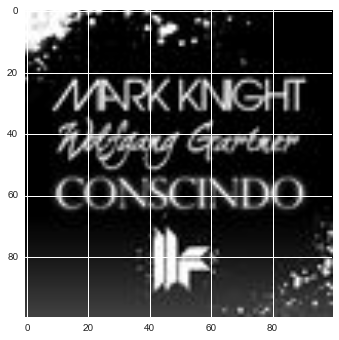

In [124]:
def show_rgb_img(img):
    #Convenience function to display a typical color image
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))

show_rgb_img(X_images[0])

In [125]:
final.iloc[y_test[0]]

artistName                           Mark Knight & Wolfgang Gartner
artworkUrl100     http://is5.mzstatic.com/image/thumb/Music/v4/b...
releaseDate                                    2010-08-09T07:00:00Z
collectionName                        Conscindo (Club Mix) - Single
decade                                                         2010
updated_genre                                                 Dance
target                                                 Dance-2010.0
Name: 79127, dtype: object

artistName                                                 Flo Rida
artworkUrl100     http://is1.mzstatic.com/image/thumb/Music/v4/a...
releaseDate                                    2008-03-17T07:00:00Z
collectionName                      Mail On Sunday (Deluxe Version)
decade                                                         2000
updated_genre                                                HipHop
target                                                HipHop-2000.0
Name: 58068, dtype: object

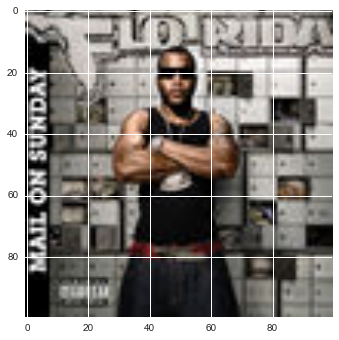

In [126]:
show_rgb_img(X_images[85])
final.iloc[y_test[85]]

artistName                                               Gene Autry
artworkUrl100     http://is4.mzstatic.com/image/thumb/Music/v4/c...
releaseDate                                    2011-10-11T07:00:00Z
collectionName                Playlist: The Very Best of Gene Autry
decade                                                         2010
updated_genre                                               Country
target                                               Country-2010.0
Name: 43019, dtype: object

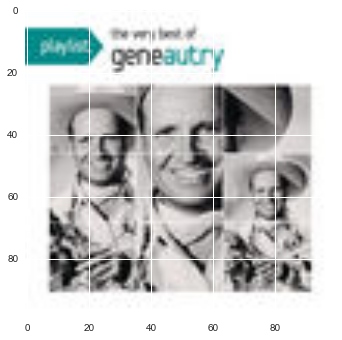

In [127]:
show_rgb_img(X_images[10000])
final.iloc[y_test[10000]]

In [128]:
y_test_genredecade = pd.DataFrame(y_test_genredecade)

In [129]:
y_test_genredecade.shape

(27484, 1)

In [156]:
#seems to be ok - now can test train split on this 20% sample with 30% test size using same method

y_test_index_genredecade, booops = StratifiedShuffleSplit(y_test_genredecade, n_iter = 2, test_size = 0.30, random_state = 77)

In [154]:
#these didn't work but this helps me remember which one is which
y_test_index_genredecade = y_test_index_genredecade[1]
y_train_index_genredecade = y_test_index_genredecade[0]

8250


TypeError: object of type 'numpy.int64' has no len()

In [165]:
len(y_test_index_genredecade[0])

19234

In [158]:
y_test_test_genredecade = [final.iloc[i][-1] for i in y_test_index_genredecade[1]]

In [161]:
y_train_test_genredecade  = [final.iloc[i][-1] for i in y_test_index_genredecade[0]]

In [163]:
#this was a mistake and I did not need this
X_test_images = [cv2.imread("./image/"+ str(i+1)+".jpg") for i in y_test_index_genredecade[1]]
X_train_images = [cv2.imread("./image/"+ str(i+1)+".jpg") for i in y_test_index_genredecade[0]]

In [167]:
X_train_images[0]

array([[[ 49,  96, 152],
        [ 44,  91, 143],
        [ 46,  89, 138],
        ..., 
        [ 24,  39,  72],
        [ 25,  40,  73],
        [ 26,  41,  74]],

       [[ 44,  82, 140],
        [ 47,  84, 140],
        [ 48,  85, 137],
        ..., 
        [ 24,  43,  78],
        [ 25,  44,  79],
        [ 27,  46,  81]],

       [[ 34,  67, 123],
        [ 43,  74, 129],
        [ 46,  77, 130],
        ..., 
        [ 26,  48,  84],
        [ 28,  50,  86],
        [ 30,  52,  88]],

       ..., 
       [[ 13,  31,  60],
        [ 20,  36,  65],
        [ 17,  33,  62],
        ..., 
        [ 12,  13,  23],
        [ 12,  13,  23],
        [ 11,  12,  22]],

       [[ 18,  34,  63],
        [ 22,  38,  67],
        [ 19,  35,  64],
        ..., 
        [ 11,  12,  22],
        [ 10,  11,  21],
        [ 10,  11,  21]],

       [[ 20,  36,  65],
        [ 25,  41,  70],
        [ 23,  37,  66],
        ..., 
        [ 10,  11,  21],
        [ 10,  11,  21],
        [  9,  10,

In [168]:
X_train_paths = ["./image/"+ str(i+1)+".jpg" for i in y_test_index_genredecade[0]]

### 3. Perform feature detection and extraction

In [171]:
fea_det = cv2.FeatureDetector_create("SIFT")
des_ext = cv2.DescriptorExtractor_create("SIFT")

des_gd_train_list = []

for image_gd in X_train_paths:
    im = cv2.imread(image_gd)
    kpts = fea_det.detect(im)
    kpts, des = des_ext.compute(im, kpts)
    des_gd_train_list.append((image_gd, des))   
    
print des_gd_train_list[1]

('./image/15732.jpg', array([[  59.,    1.,    0., ...,    0.,    0.,    0.],
       [  46.,    1.,    0., ...,    3.,    8.,    6.],
       [  23.,    0.,    0., ...,    0.,    3.,    5.],
       ..., 
       [  13.,   64.,  129., ...,    0.,    0.,    0.],
       [  45.,   13.,    2., ...,    0.,    0.,    0.],
       [  79.,   44.,   18., ...,    0.,    0.,    0.]], dtype=float32))


In [192]:
len(des_gd_train_list)

19234

In [193]:
des_gd_train_list[1]

('./image/15732.jpg', array([[  59.,    1.,    0., ...,    0.,    0.,    0.],
        [  46.,    1.,    0., ...,    3.,    8.,    6.],
        [  23.,    0.,    0., ...,    0.,    3.,    5.],
        ..., 
        [  13.,   64.,  129., ...,    0.,    0.,    0.],
        [  45.,   13.,    2., ...,    0.,    0.,    0.],
        [  79.,   44.,   18., ...,    0.,    0.,    0.]], dtype=float32))

In [188]:
#just testing to see what is happening
print des_gd_train_list[0][1]

[[  6.   3.   4. ...,  12.  20.   4.]
 [  4.  12.  20. ...,   3.   4.   3.]
 [  0.   0.   1. ...,  36.  16.   9.]
 ..., 
 [  7.   0.   0. ...,   7.   1.  10.]
 [ 21.   3.   0. ...,  17.   6.  22.]
 [  1.   0.   0. ...,  15.  10.   0.]]


In [198]:
print len(des_gd_train_list[1][1])
print des_gd_train_list[2][1]

114
[[   0.    8.   50. ...,    6.   41.    0.]
 [   0.    1.   27. ...,    2.   27.    1.]
 [  12.  100.   95. ...,  103.    3.   11.]
 ..., 
 [   3.   46.  125. ...,   10.   44.   12.]
 [   1.    0.    0. ...,    0.    1.    4.]
 [   2.   14.   35. ...,    0.   26.   13.]]


In [199]:
for i in range(1,8):
    print len(des_gd_train_list[i][1])

114
216
19
138
122
142
51


In [200]:
#move the descriptors into an array
descriptors = des_gd_train_list[0][1]
for image_path, descriptor in des_gd_train_list[1:]:
    descriptors = np.vstack((descriptors, descriptor)) 

ValueError: all the input array dimensions except for the concatenation axis must match exactly